### Installation of required packages

In [14]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib seaborn
! pip install pyahocorasick Bio pybmoore ahocorasick_rs

# pip install requirements.txt

### Imports and initialization

In [ ]:
import pytest
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

import time
import psutil
import logging
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

from collections import defaultdict
from Bio import SeqIO #type: ignore

### Data for benchmarking

In [19]:
from Bio import SeqIO

def load_peptides_txt(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

def load_proteome_fasta(path):
    """
    Retourne une liste de tuples (protein_id, sequence)
    """
    return [(rec.id, str(rec.seq)) for rec in SeqIO.parse(path, "fasta")]


In [20]:
peptides = load_peptides_txt("Peptides.txt")

proteome = load_proteome_fasta(
    "uniprotkb_proteome_UP000000803_2025_11_25.fasta"
)

### Matching algorithms to benchmark 

In [17]:
import pybmoore 

import ahocorasick
from ahocorasick_rs import AhoCorasick
import subprocess
import tempfile
import os
import shutil as sh

In [23]:
from bench_functions import (
    run_ahocorasick_mem,
    run_ahocorasick_rs_mem,
    run_find_mem,
    run_in_mem,
    run_blast_mem
    )


In [24]:
class TestBenchmarkFunctions:
    """Test suite for string matching benchmark functions"""

    @pytest.fixture
    def sample_data(self):
        """Provide sample text and patterns for testing"""
        return {
            "text": "A" * 1000 + "B" * 500 + "ABCABCABC" * 100,
            "pattern_single": "ABC",
            "patterns_multiple": ["A", "B", "C", "ABC", "BC", "AB"]
        }

    def test_aho_corasick_search(self, sample_data):
        """Test Aho-Corasick search with multiple patterns"""
        result = aho_corasick_search(sample_data["text"], sample_data["patterns_multiple"])
        assert result is not None
        assert isinstance(result, (list, dict, tuple))

    def test_boyer_moore_search(self, sample_data):
        """Test Boyer-Moore search with single pattern"""
        result = boyer_moore_search(sample_data["text"], sample_data["pattern_single"])
        assert result is not None

    def test_knuth_morris_pratt_search(self, sample_data):
        """Test Knuth-Morris-Pratt search with single pattern"""
        result = knuth_morris_pratt_search(sample_data["text"], sample_data["pattern_single"])
        assert result is not None

    def test_match_boyermoore_text(self, sample_data):
        """Test Boyer-Moore text matching"""
        result = match_boyermoore_text(sample_data["text"], sample_data["pattern_single"])
        assert result is not None

    def test_grep_like_match(self, sample_data):
        """Test grep-like pattern matching"""
        result = grep_like_match(sample_data["text"], sample_data["pattern_single"])
        assert result is not None

    def test_grep_like_fasta_match(self, sample_data):
        """Test grep-like FASTA pattern matching"""
        result = grep_like_fasta_match(sample_data["text"], sample_data["pattern_single"])
        assert result is not None

    def test_functions_with_empty_pattern(self, sample_data):
        """Test behavior with empty patterns"""
        text = sample_data["text"]
        # Most functions should handle empty strings gracefully
        result = boyer_moore_search(text, "")
        assert result is not None

In [25]:
# Exemple de texte et motifs
#text = "A" * 1000 + "B" * 500 + "ABCABCABC" * 100
#patterns_single = "ABC"
#patterns_multiple = ["A", "B", "C", "ABC", "BC", "AB"]



# Liste des fonctions à tester
#from bench_functions import run_ahocorasick_mem, run_ahocorasick_rs_mem, run_find_mem, run_in_mem, run_blast_mem

TESTS = [
    (run_ahocorasick_mem, (peptides, proteome)),  # note le tuple comme argument
    (run_ahocorasick_rs_mem, (peptides, proteome)),
    (run_find_mem, (peptides, proteome)),
    (run_in_mem, (peptides, proteome)),
    #(run_blast_mem, (peptides, proteome_fasta_path)),
]


In [26]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

### Single-run measurement utility

In [27]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [28]:
def benchmark(fn, runs=5, args=()):
    """
    Run a function several times with positional arguments and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, *args)  # dépaqueter le tuple
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "args": args,
        "time_mean": avg_time,
    }



### Sequential execution + progress bar

In [29]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=5, args=params)  # <- args=params, no *
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


,function,args,time_mean
0,run_ahocorasick_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",0.294862
1,run_ahocorasick_rs_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",0.145550
2,run_find_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",2.285448
3,run_in_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",1.756950


### Metrics

In [30]:
def run_single_with_metrics(test):
    func, args = test # args can be a tuple or a dict
    if isinstance(args, dict):
        args = (args.get("size", 0),)  # -> tuple
    elif not isinstance(args, tuple):
        args = (args,)  # transform in tuple if only 1 argument

    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # en MB

    import time
    start = time.time()
    result = func(*args)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # en MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }

### DataFrame creation

In [31]:
# Exécution parallèle avec ThreadPoolExecutor (safe dans Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)



Index(['function', 'argument', 'result', 'time_sec', 'cpu_mean',
       'mem_mean_MB'],
      dtype='object')


### Visualisation of results (boxplot + violin)

<Figure size 640x480 with 0 Axes>

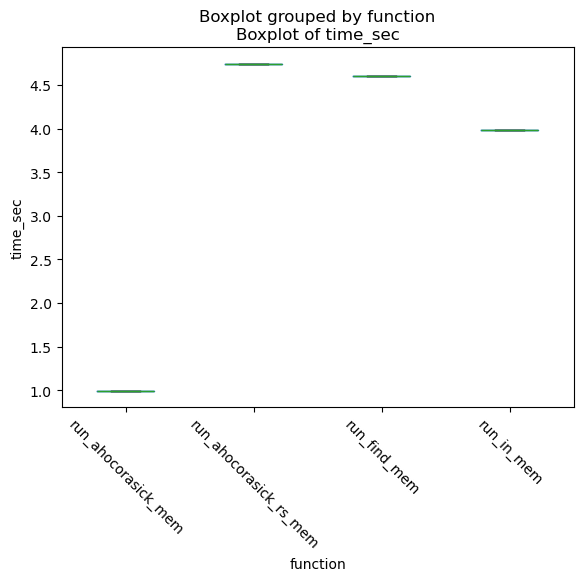

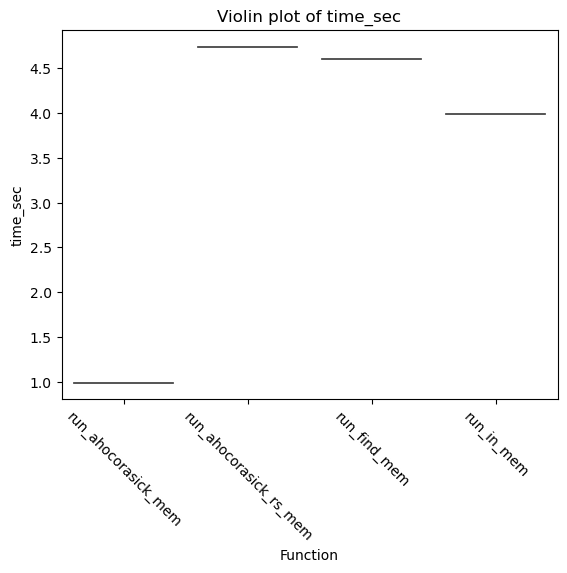

<Figure size 640x480 with 0 Axes>

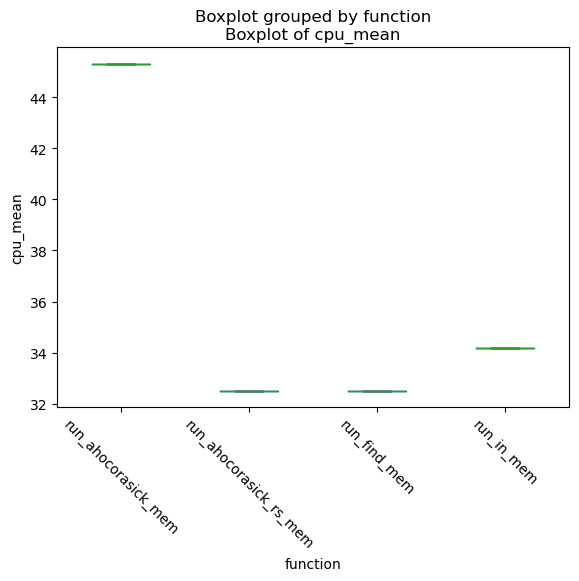

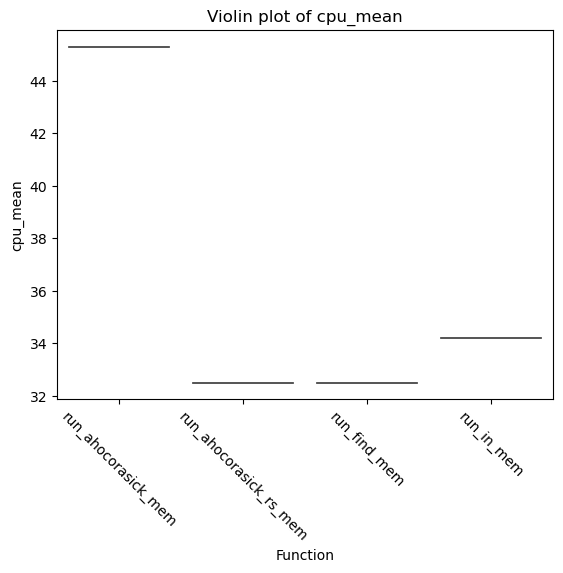

<Figure size 640x480 with 0 Axes>

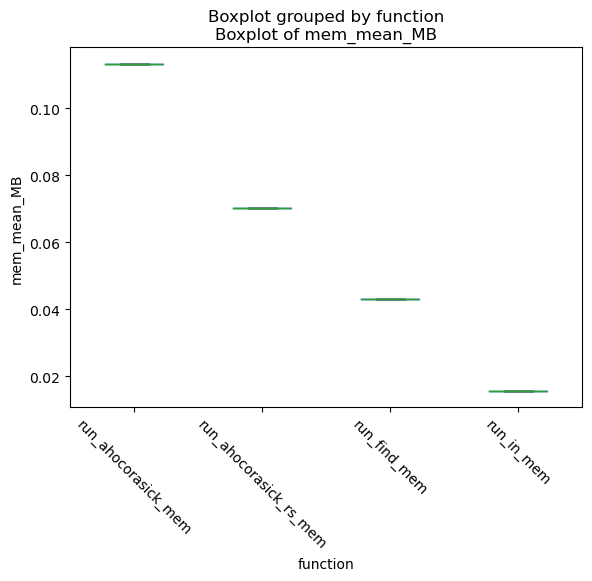

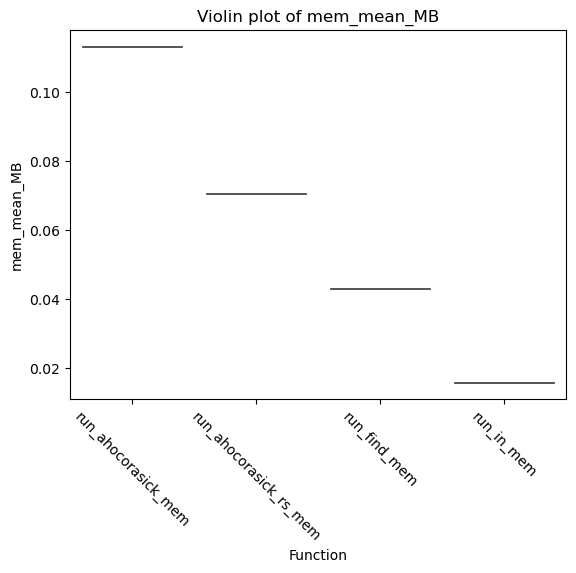

In [32]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

for m in metrics:
    # Boxplot avec Pandas
    plt.figure()
    ax = df_parallel.boxplot(column=[m], by="function", grid=False)
    plt.title(f"Boxplot of {m}")
    plt.xlabel("function")
    plt.ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()

    # Violin plot avec Seaborn
    plt.figure()
    ax = sns.violinplot(x="function", y=m, data=df_parallel)
    plt.title(f"Violin plot of {m}")
    ax.set_xlabel("Function")
    ax.set_ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()


### Export results

In [12]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")


Benchmark exports complete.
